### Requirements

In [3]:
!pip install -q -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# reload modules before executing user code
%load_ext autoreload
%autoreload 2

### Data & Model

In [ ]:
from huggingface_hub import hf_hub_download

vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors")
realisticVision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors")

In [ ]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(
    'stabilityai/stable-diffusion-2-inpainting',
    subfolder="tokenizer",
)

In [ ]:
from model import get_models, get_ddim_scheduler
text_encoder, vae, unet, tokenizer = get_models(
    realisticVision_path,
    vae_path,
    device="cuda:0",
    load_from_safetensor=True,
)

noise_scheduler = get_ddim_scheduler(realisticVision_path)

In [55]:
from dataset import SFTInpaintDataset

PATH = './data/train'
dataset = SFTInpaintDataset(
    PATH,
    tokenizer,
    global_caption=None,
    max_size=768,
    resize=True,
    normalize=True,
    noise_offset=0.1,
    train_inpainting=True,
)

In [56]:
from dataloader import SFTDataloader

train_dataloader = SFTDataloader(
    dataset,
    tokenizer,
    batch_size=1,
    shuffle=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 640, 512])


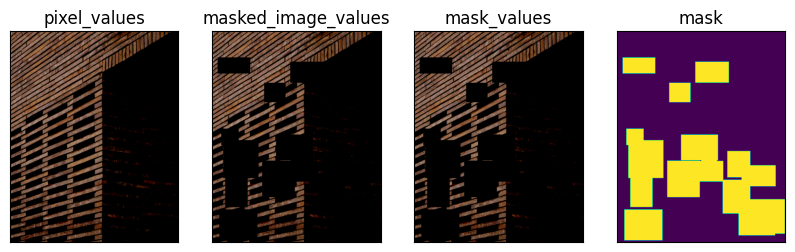

In [69]:
# plot some images
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(train_dataloader))

# plot the batch
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("pixel_values")
plt.imshow(batch["pixel_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 2)
plt.title("masked_image_values")
plt.imshow(batch["masked_image_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 3)
plt.title("mask_values")
plt.imshow(batch["mask_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(batch["mask"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

### Training

In [ ]:
config = {
    "lr": 1e-4,
    "weight_decay": 0.0,
    "epochs": 100,
    "val_epochs": 10,
}

trainer = SFTTrainer(
    unet,
    vae,
    text_encoder,
    noise_scheduler,
    train_dataloader,
    val_dataloader,
    device="cuda:0",
)

trainer.print_model_info()

In [ ]:
trainer.fit(config)